# Pair Programming 11 - Decision Tree

En el pair programming de hoy debéis usar el csv que guardastéis cuando hicistéis el pairprgramming de codificicación (este csv debería tener las variables estadandarizas).

En pairprogramming anteriores ajustastéis vuestro datos a una regresión lineal. El objetivo de hoy es:

- Ajustar el modelo a un Decision Tree
- Extraer las métricas
- Debatid entre vosotras qué modelo es mejor y por qué (basándose en las métricas)

In [1]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

In [2]:
df = pd.read_csv('datos/pokePd_estandarizado.csv', index_col = 0)

In [3]:
df.head(2)

,Type,Total,HP,Attack,Defense,Sp.Atk,Sp.Def,Speed_BOX
0,Grass,-0.819945,-0.75,-0.738095,-0.5,-0.088889,-0.131579,16.160251
1,Poison,-0.819945,-0.75,-0.738095,-0.5,-0.088889,-0.131579,16.160251


In [4]:
# al igual que en la regresión lineal tenemos que separar nuestro dataframe en X e y

X = df.drop(["Speed_BOX", 'Type'], axis = 1)
y = df["Speed_BOX"]

In [5]:
# y dividir nuestros datos en train y test para poder evaluar la bondad de nuestro modelo

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [6]:
# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol = DecisionTreeRegressor(random_state =0)

In [7]:
# ajustamos el modelo, igual que en la regresión lienal. 
arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

In [8]:
# max features 

max_features = np.sqrt(len(x_train.columns))
max_features

2.449489742783178

In [9]:
#max depth

print(arbol.tree_.max_depth)

20


In [10]:
param = {"max_depth": [2,4, 6], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, la nuestra anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2,3],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]}

In [11]:
gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

In [12]:
# ajustamos el modelo que acabamos de definir en el GridSearch

gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 4, 6], 'max_features': [1, 2, 3],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [13]:
# este método nos esta diciendo que el mejor modelo es aquel que tiene una profundidad de 6, que usa 4 variables predictoras para construir el modelo y que tiene  un min_samples_leaf y un min_samples_split de 10. 
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=6, max_features=3, min_samples_leaf=10,
                      min_samples_split=10)

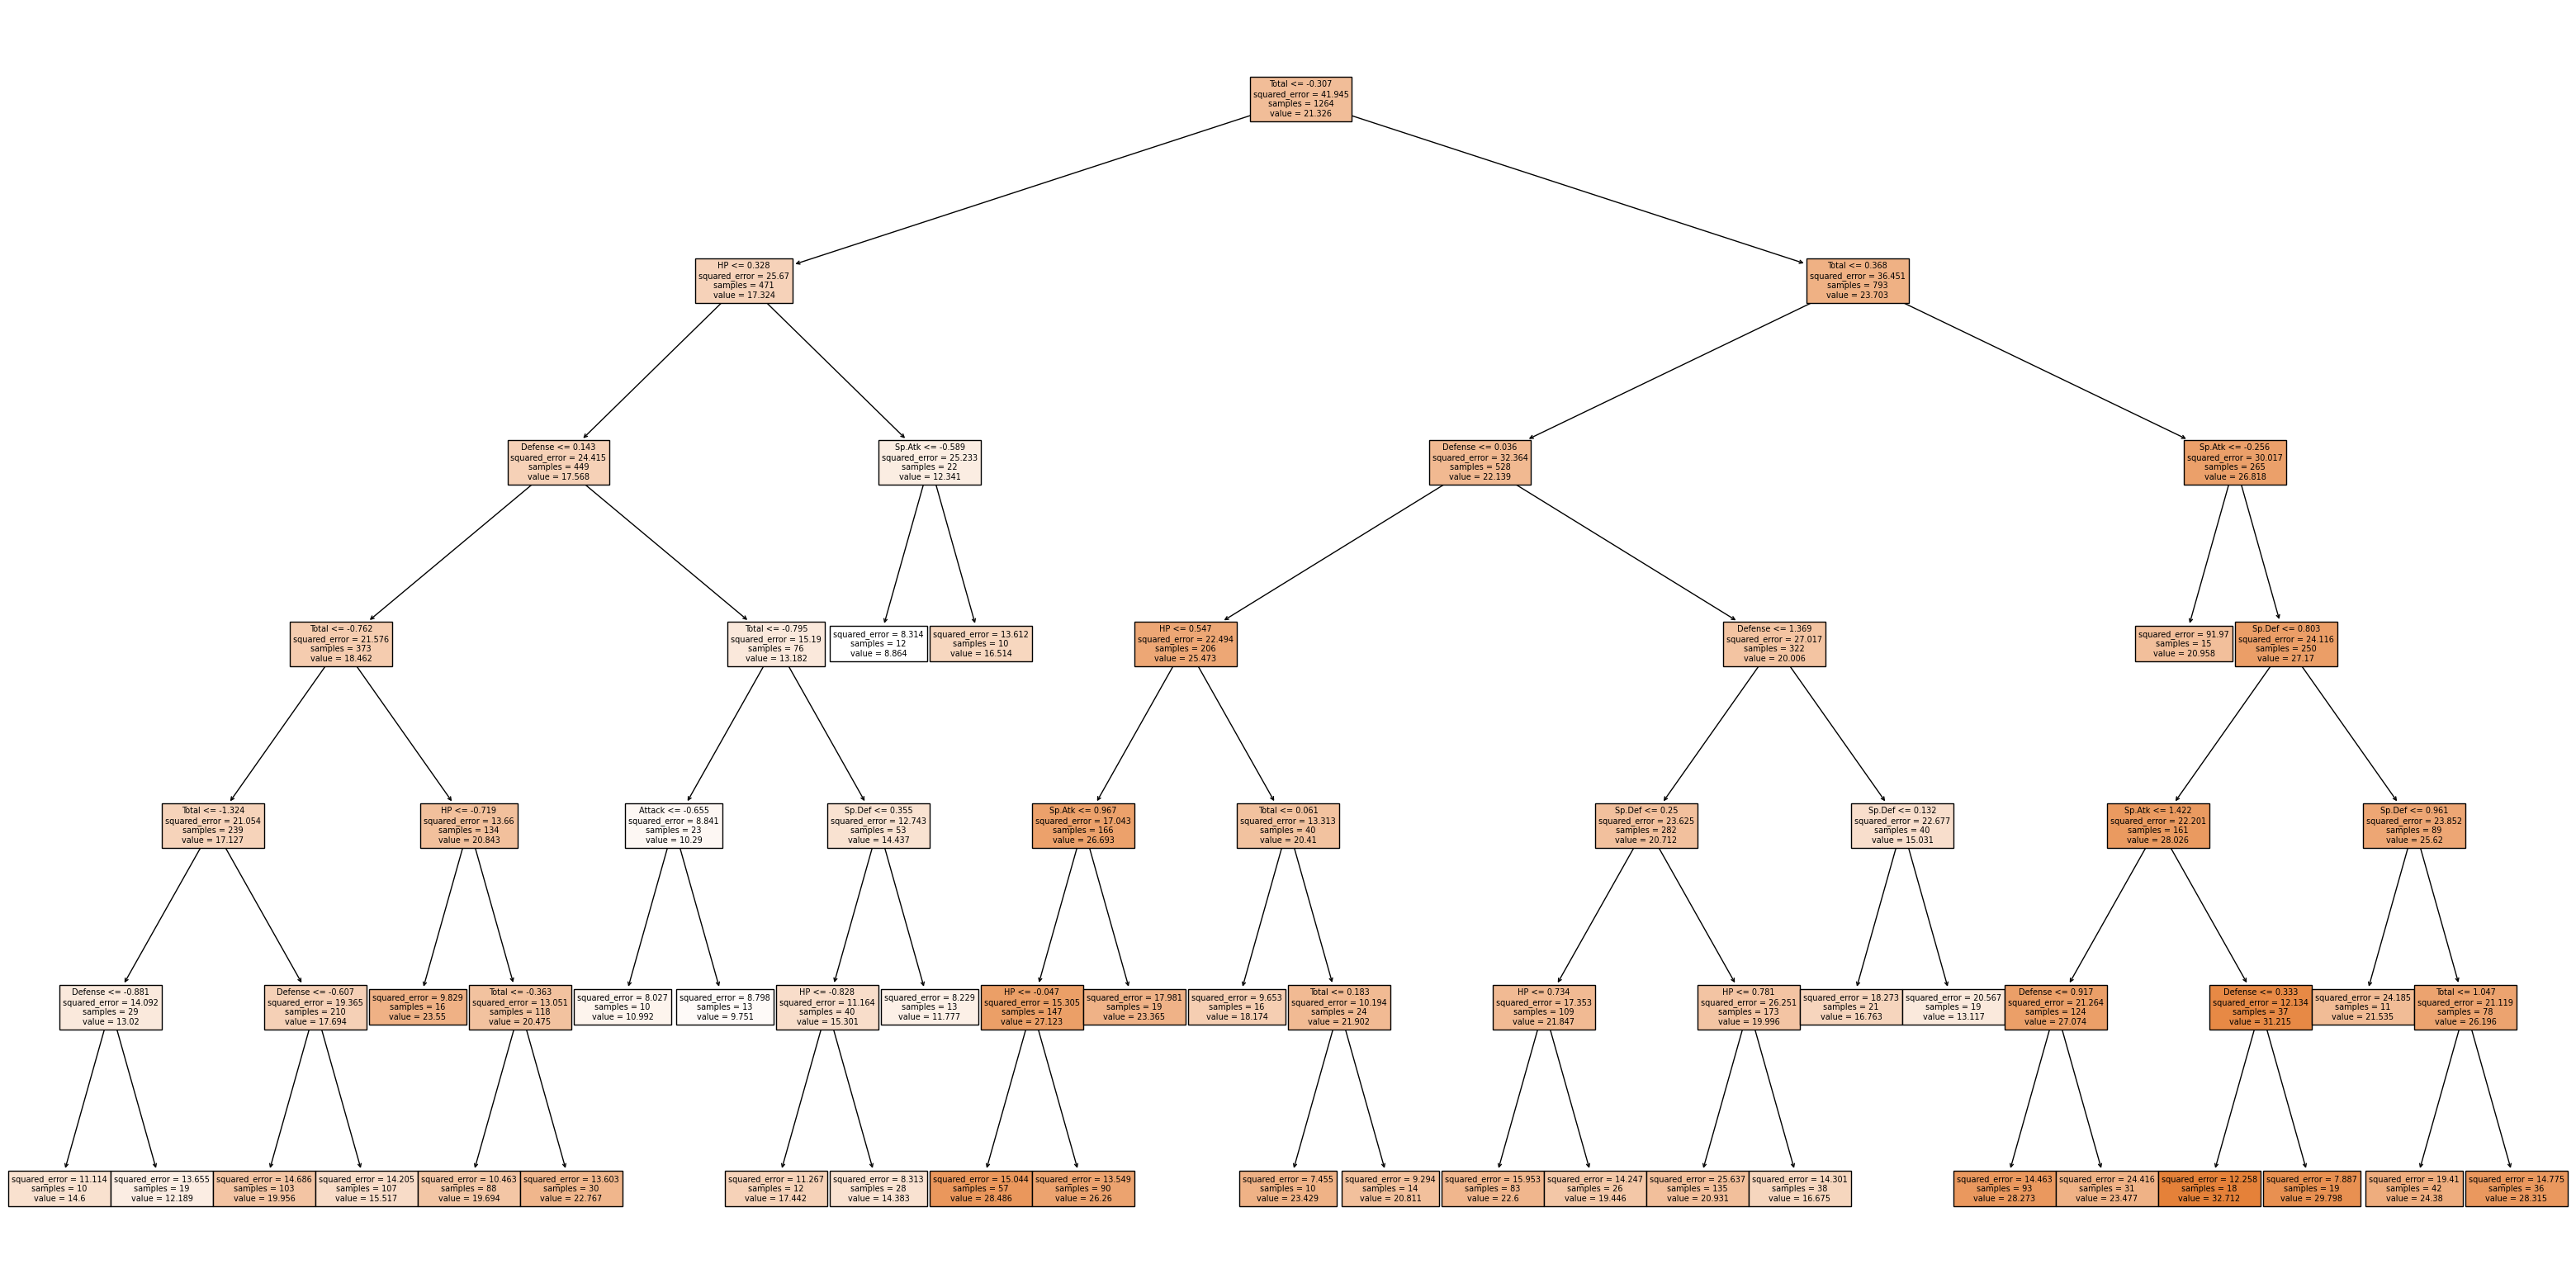

In [14]:
# veamos ahora que pinta tiene nuestro árbol

fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo, feature_names=x_train.columns, filled=True);

In [15]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [16]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

In [17]:
dt_results = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decision tree I")
dt_results

,MAE,MSE,RMSE,R2,set,modelo
0,1.899720e+00,1.484213e+01,3.852549e+00,0.666688,test,Decision tree I
1,6.113253e-17,1.891019e-31,4.348585e-16,1.000000,train,Decision tree I


In [18]:
df_rl = pd.read_csv('datos/pokePdresultados.csv', index_col = 0)
df_rl.head(2)

,MAE,MSE,RMSE,R2,set,modelo
0,0.459946,0.409424,0.639862,0.990806,test,Linear Regresion
1,0.468912,0.453642,0.673530,0.989185,train,LinearRegression


In [20]:
df_resultado_final = pd.concat([dt_results, df_rl], axis = 0)
df_resultado_final.head()

,MAE,MSE,RMSE,R2,set,modelo
0,1.899720e+00,1.484213e+01,3.852549e+00,0.666688,test,Decision tree I
1,6.113253e-17,1.891019e-31,4.348585e-16,1.000000,train,Decision tree I
0,4.599458e-01,4.094236e-01,6.398622e-01,0.990806,test,Linear Regresion
1,4.689115e-01,4.536421e-01,6.735296e-01,0.989185,train,LinearRegression


  ##### COMENTARIO:
  
- Vemos que los valores del train en el DECISION TREE son mucho mejores que los obtenidos en el análisis de métricas de REGRESIÓN LINEAL, obteniendo un mejor R2 y una horquilla de error en el RMSE mucho más baja que en la REGRESIÓN LINEAL.

- Vemos también en el DECISION TREE, los valores del train también son mejores que los del test, ya que el valor de R2 es alto y el de las métricas son valores bajos. En este caso, tendríamos que revisar si se está produciendo overfitting.

In [22]:
df_resultado_final.to_csv('datos/comparacion_regresion_decision.csv')

In [23]:
# vamos a crearnos un dataframe con el grado de importancia de nuestras variables predictoras

importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': mejor_modelo.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
0,Total,0.571817
3,Defense,0.256263
1,HP,0.091169
4,Sp.Atk,0.048956
5,Sp.Def,0.031527
2,Attack,0.000268


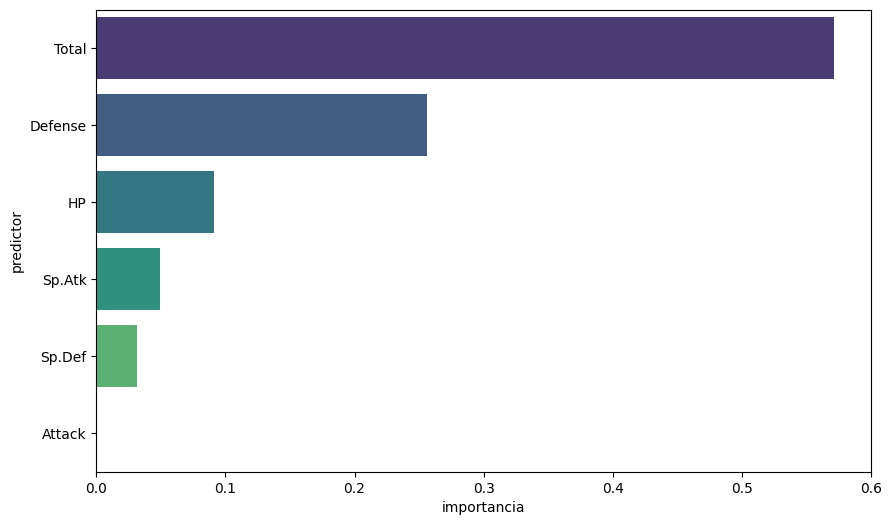

In [24]:
# por último, sacamos un gráfico con los resultados para verlo de una forma más amigable

plt.figure(figsize=(10,6)) 
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()

- En este gráfico se pueden ver las variables más importantes para el modelo predictivo, es decir, qué variables ayudan a explicar mejor el valor de la velocidad. Como se puede obserar están en orden de importancia, por lo que podemos deducir que nuestras mejores variables predictoras para nuestra VR son el "Total de puntos" seguida de la "Defensa". 